## Code and Documentation to Decode Hex Pop-up Buoy Bottom Data and Calculate Temperature Calibration Coefficients

Translation code should be identical to rudics transmitted data except treated entirely as if "bottom" data

## Software Requirements

Developed/tested for:
- python >=3.7 

requires:
- pyyaml >= 3.13 
- pandas >= 0.23.4
- numpy >= 1.15.4


In [85]:
import numpy as np
import pandas as pd
import yaml
import collections
from netCDF4 import num2date
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys

In [86]:
# change the INPUT to be appropriate to each float
year       = '2020' #<--INPUT year 
sn         = '9200' #<-- INPUT float serial number
tb_file    = 'TB120065.CAL' #<-- INPUT temperature bath calibration (.CAL) file 

In [87]:
#these should remain the same for each unit
input_path = './' + year + '/' + sn + '/temp'
input_file = 'BOTDAT.TXT' #<--BOTDAT.TXT file taken off the units' SD card after logging in the temperature bath at 30 second sample frequency
instconfig = input_path +'/tempcal.yaml' #<--yaml must be edited to have proper configuration parameters for converted values (ENTER UNIT START DATE_TIME, LEAVE TEMP COEFF as 1000)

# Load temperature bath calibration file, copied to floppy disc from the temperature bath program 

In [88]:
# use pandas pd.read_csv to load TB######.CAL file into python as a dataframe array
# need to target lines 11-550, therefore set skiprows=10
# skipinitialspace : bool, default False, Skips spaces after delimiter
# using tb infront of all column names to identify this as temperature bath data
colnames = ['tbdate', 'tbtime', 'tbtemp', 'tbSBEfreq', 'tbSBEtemp']

tb_cal   = pd.read_csv(input_path +'/'+ tb_file, header=None, skiprows=10, delimiter=" ", skipinitialspace=True, names=colnames) #<--INPUT--TB#######.CAL file name 
tb_cal.head(3) #<-- tb_cal is the temperature bath calibration file that is pulled off the floppy disk, parsed down to only the relevant data

,tbdate,tbtime,tbtemp,tbSBEfreq,tbSBEtemp
0,03-05-2020,22:36:20,-2.001,6324.289,-1.997
1,03-05-2020,22:36:36,-2.003,6324.182,-1.998
2,03-05-2020,22:36:52,-2.003,6324.160,-1.998


In [89]:
def signed_int(hexstr):
    '''function to convert hex string to signed int'''
    s_int = int(hexstr,16)
    if s_int >= 0x8000:
        s_int -= 0x10000  

    return(s_int)

class PopUpBuoys(object):
    """Class definitions to read and Process PopUp Buoy Data Streams"""


    active_stream = 'bottom'
    def __init__(self, path, instfile_dic=None):
        self.path = path
        if not instfile_dic:
            self.instfile_dic = {'bottom': path + '/BOTDAT.TXT',
                                 'ice': path + '/ICEDAT.TXT',
                                 'profile': path + '/PRODAT.TXT',
                                 'sst': path + '/SSTDAT.TXT'}
        else:
            self.instfile_dic = instfile_dic
    
    def LoadCoefs(self, config_file='default.yaml'):
        ''' Load yaml formated config file '''
        self.config = yaml.safe_load(open(config_file))

    
    def HexView(self, active_stream='', verbose=True):
        '''
        input: reference to proper filepointer, options are keys 
            to the self.instfile_dic dictionary
        '''
        if active_stream:
            self.active_stream = active_stream
            
        file = self.instfile_dic[self.active_stream]
        with open(file, 'rb') as in_file:
            while True:
                hexdata = in_file.read().hex().upper()     
                if len(hexdata) == 0:                      
                # breaks loop once no more binary data is read
                    break
                self.hexstr = hexdata.upper()
                
                if verbose:
                    return(hexdata.upper())

    def HexSplit(self, verbose=True):
        '''
        input: results of HexView (inherits output)
        '''
        if self.hexstr.find('FFFFF') == -1:
            print("No FFFFF, proceed to split on FFFF")
            #because in this case the first index is empty
            sample_raw = self.hexstr.split('FFFF')[1:] 
        else:
            print('FFFFF found')
            #this puts in the proper line endings but removes a variable 
            #   F from the end of each string.  Add the F string back
            sample_raw = []
            for substr in self.hexstr.split('FFFFF'): 
                sample_raw = sample_raw + (substr + 'F').split('FFFF')

            sample_raw[-1] = sample_raw[-1][:-1]
        
        self.sample_raw = sample_raw
        
        if verbose:
            return(sample_raw)
    
    def Bottom(self, asPandas=False):
        ''' Bottom is equivalent to the TimeSeriesBase'''
        
        if self.active_stream != 'bottom':
            print("current active file is {} - can't output bottom data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()

        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
    

    def Profile(self, asPandas=False):
        try:
            self.sample_raw
        except:
            print("Run PopUpBuoys.HexView and PopUpBuoys.HexSplit First")
            return

        if self.active_stream != 'profile':
            print("current active file is {} - can't output profile data".format(self.active_stream))
            return
                        
        data=collections.OrderedDict()

        for sample_num, sample in enumerate(self.sample_raw):
                        
            if len(sample) == 22: #2byte timeword
                
                # unlike sst, bottom, and ice - profiles don't need to be multiplied by a sample interval
                #seconds since 1970-01-01
                try:
                    time = int(sample[0:4],16)/100 + profile_starttime
                except:
                    time = int(sample[0:4],16)/100 + 0
                    
                pressure =  self.PressureConversion(int(sample[4:8],16)) 
                
                fr_temp_ADC = signed_int(sample[8:12])
                fr_temp = self.TempConversion(engr_meas=fr_temp_ADC,
                                                  coefA=self.config['fr_temp_cal']['Acoef'], 
                                                  coefB=self.config['fr_temp_cal']['Bcoef'],
                                                  coefC=self.config['fr_temp_cal']['Ccoef'])

                rawpvalue = signed_int(sample[12:16])                  
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])   

                rawfvalue = signed_int(sample[16:20])                   
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[20:22],16) #degrees
                
            elif len(sample) == 26: #4byte timeword, reserved for profile starttime
                
                #seconds since 1970-01-01
                profile_starttime = int(sample[0:8],16)
                
                time = profile_starttime
                
                pressure =  self.PressureConversion(int(sample[8:12],16))  
                
                fr_temp_ADC = signed_int(sample[12:16])
                fr_temp = self.TempConversion(engr_meas=fr_temp_ADC,
                                                  coefA=self.config['fr_temp_cal']['Acoef'], 
                                                  coefB=self.config['fr_temp_cal']['Bcoef'],
                                                  coefC=self.config['fr_temp_cal']['Ccoef'])
                
                rawpvalue = signed_int(sample[16:20])             
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])  

                rawfvalue = signed_int(sample[20:24])                
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[24:26],16) #degrees
            
            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'fr_temp':fr_temp,
                                'fr_temp_ADC':fr_temp_ADC,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}        
        
        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
        
    def Ice(self, asPandas=False):
        ''' Ice is equivalent to the TimeSeriesBase'''

        if self.active_stream != 'ice':
            print("current active file is {} - can't output ice data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()

        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
    
    def SST(self, asPandas=False):
        ''' SST is equivalent to the TimeSeriesBase + GPS information'''
        
        if self.active_stream != 'sst':
            print("current active file is {} - can't output sst data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()


        for sample_num, sample in enumerate(self.sample_raw):

            if (len(sample) == 30) or (len(sample) == 66): #2byte timeword, no TTS (w and w/o gps)
                TTS = np.nan
                if len(sample) == 66:
                    print("analyze GPS")
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif (len(sample) == 32) or (len(sample) == 68): #2byte timeword, yes TTS (w and w/o gps)
                TTS = int(sample[30:32],16)
                if len(sample) == 68:
                    gps_data = self.GPSSeriesBase(sample_num, sample, offset=2, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif (len(sample) == 34) or (len(sample) == 70): #4byte timeword, no TTS (w and w/o gps)
                TTS = np.nan
                if len(sample) == 70:
                    gps_data = self.GPSSeriesBase(sample_num, sample, offset=4, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif (len(sample) == 36) or (len(sample) == 72): #4byte timeword, yes TTS (w and w/o gps)
                TTS = int(sample[30:32],16)
                if len(sample) == 72:
                    gps_data = self.GPSSeriesBase(sample_num, sample, offset=6, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary

            try:
                data[sample_num].update({'TTS':TTS})        
                data[sample_num].update(gps_data[sample_num])
            except:
                pass

        if asPandas:
            return(pd.DataFrame.from_dict(data,orient='index'))
        else:
            return(data)


    ### The folowing BASE functions are for convenience for reading and coding.  All redundant
    # pattern reads are below.  The only challenge is that each BASE function reads the entire hex
    # string (non-issue for files of size we expect)
    def GPSSeriesBase(self,sample_num, sample, offset=0, empty=True):
        '''SST only, the last 18 bytes are the same format:
         GPSLat, GPSLon, GPSDate, GPSTime, TTF, Max_Tilt
         Regardless of whether TTS or longdates are used.  This subroutine returns the 
         GPS dictionary based on a byte offset given the record length

         Passing empty=True sends missing data back for GPS Data'''
        data=collections.OrderedDict()

        if not empty:
            GPSLat = int(sample[30+offset:38+offset],16)/1000000
            GPSLon = int(sample[38+offset:46+offset],16)/1000000
            GPSDate = int(sample[46+offset:54+offset],16)
            GPSTime = int(sample[54+offset:62+offset],16)
            TTF = int(sample[62+offset:64+offset],16)
            Max_Tilt = int(sample[62+offset:66+offset],16)   

        else:
            GPSLat = GPSLon = GPSDate = GPSTime = TTF = Max_Tilt = np.nan 
            
        #save to dictionary
        data[sample_num] = {'GPSLat':GPSLat,
                            'GPSLon':GPSLon,
                            'GPSDate':GPSDate,
                            'GPSTime':GPSTime,
                            'TTF':TTF,
                            'Max_Tilt':Max_Tilt}  
            
        return(data)   

    def TimeSeriesBase(self):
        '''Bottom, Ice, and SST all have the same base transmission information,
            e.g. the first 17 bytes (short time stamp) / 19 bytes (long time stamp)
            are the same.  Each of the appropriate modules will call this communal module
            first.

            Bottom and Ice don't report any additional information beyond the base info so 
            they are essential decorators/wrappers for this function

            Returns: Dictionary'''
        try:
            self.sample_raw
        except:
            print("Run PopUpBuoys.HexView and PopUpBuoys.HexSplit First")
            return

        data=collections.OrderedDict()

        for sample_num, sample in enumerate(self.sample_raw):
            
            #record length conditionals are due to number of varying outputs
            #SST dominates the number of options due to:
            # 2byte timeword, no TTS, no GPS (30)
            # 4byte timeword, yes TTS, yes GPS (72)
            #  and every permutation of the three functions
            if ((len(sample) == 30) or (len(sample) == 32) or 
                            (len(sample) == 60) or (len(sample) == 64) or (len(sample) == 66) or (len(sample) == 68)) : #2byte timeword
                
                #seconds since 1970-01-01
                if self.active_stream in ['sst']:
                    time_base = date2num(datetime.datetime.strptime(IDNUMBER.config['Unit_Release_Time'],
                                      '%Y-%m-%d %H:%M:%S'),'seconds since 1970-1-1')
                else:
                    time_base = 0

                time = int(sample[0:4],16) * self.config['sample_interval'][self.active_stream] + time_base
                
                pressure =  self.PressureConversion(int(sample[4:8],16))  
                
                fr_temp_ADC = signed_int(sample[8:12])
                fr_temp = self.TempConversion(engr_meas=fr_temp_ADC,
                                                  coefA=self.config['fr_temp_cal']['Acoef'], 
                                                  coefB=self.config['fr_temp_cal']['Bcoef'],
                                                  coefC=self.config['fr_temp_cal']['Ccoef'])

                sr_temp_ADC = signed_int(sample[12:16])
                sr_temp = self.TempConversion(engr_meas=sr_temp_ADC,
                                                  coefA=self.config['sr_temp_cal']['Acoef'], 
                                                  coefB=self.config['sr_temp_cal']['Bcoef'],
                                                  coefC=self.config['sr_temp_cal']['Ccoef'])

                temp_ref = signed_int(sample[16:20])               
                
                rawpvalue = signed_int(sample[20:24])               
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope']) 
                
                rawfvalue = signed_int(sample[24:28])                 
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[28:30],16) #degrees
                
            elif ((len(sample) == 34) or (len(sample) == 36) or (len(sample) == 72)) : #4byte timeword
                
                #seconds since 1970-01-01
                time = int(sample[0:8],16)
                
                pressure =  self.PressureConversion(int(sample[8:12],16))   
                
                fr_temp_ADC = signed_int(sample[12:16])
                fr_temp = self.TempConversion(engr_meas=fr_temp_ADC,
                                                  coefA=self.config['fr_temp_cal']['Acoef'], 
                                                  coefB=self.config['fr_temp_cal']['Bcoef'],
                                                  coefC=self.config['fr_temp_cal']['Ccoef'])

                sr_temp_ADC = signed_int(sample[16:20])
                sr_temp = self.TempConversion(engr_meas=sr_temp_ADC,
                                                  coefA=self.config['sr_temp_cal']['Acoef'], 
                                                  coefB=self.config['sr_temp_cal']['Bcoef'],
                                                  coefC=self.config['sr_temp_cal']['Ccoef'])

                temp_ref = signed_int(sample[20:24])          
                
                rawpvalue = signed_int(sample[24:28])                 
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])  

                rawfvalue = signed_int(sample[28:32])               
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  
                
                tilt = int(sample[32:34],16) #degrees            

            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'fr_temp':fr_temp,
                                'fr_temp_ADC':fr_temp_ADC,
                                'sr_temp':sr_temp,
                                'sr_temp_ADC':sr_temp_ADC,
                                'temp_ref':temp_ref,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}  
        return(data)

    @staticmethod
    def PARConversion(engr_meas,coef_offset, coef_slope):
        ''' Calculate PAR from raw measurement
        
            (ADC_val - coef_offset) * coef_slope / 0.73

            output is PAR in umolm-2s-1
        '''
        return((engr_meas - coef_offset) * coef_slope / 0.73 )

    @staticmethod
    def FluorConversion(engr_meas,coef_offset, coef_slope):
        ''' Calculate Fluometer from raw measurement

            (ADC_val - coef_offset) * coef_slope
        
            output is concentration in ug/L
        '''
        return((engr_meas - coef_offset) * coef_slope) 

    @staticmethod
    def PressureConversion(engr_meas):
        ''' Calculate Pressure from raw measurement

            (ADC_val - 16384) * 10 / 32768
        
            output is Pressure in Bars
        '''
        return((engr_meas - 16384) * 10 / 32768)

    @staticmethod
    def TempConversion(engr_meas, coefA, coefB, coefC):
        ''' Calculate Temperature from raw measurement.

        1 / ( coefA + 
              coefB*np.log(ADC_val) + 
              coefC*np.log(ADC_val)^3 ) - 273.15

        Output is Temperature in DegC
        '''
        temperature = 1 / ( coefA + 
                     coefB*np.log(engr_meas) + 
                     coefC*np.log(engr_meas)**3 ) - 273.15    

        return(temperature)        

In [90]:
IDNUMBER = PopUpBuoys(path=input_path,instfile_dic={'bottom': input_path +'/'+ input_file})

In [91]:
IDNUMBER.LoadCoefs(config_file=instconfig)
IDNUMBER.HexView(active_stream='bottom',verbose=False)
IDNUMBER.HexSplit(verbose=True)#<-- change verbose to True to get an output like D. Langis had

['',
 '000001B268B8687C21561559FE25B0',
 '000101B268C9688921561559FE25B0',
 '000201B268D8689721561559FE25B0',
 '000301B268E868A521561559FE25B1',
 '000401B268F568B421561559FE25B0',
 '000501B2690468C821561559FE25B0',
 '000601B2691568D621561559FE25B0',
 '000701B2692268EA21561559FE25B0',
 '000801B2693468F821561559FE25B1',
 '000901B26943690021561559FE25B0',
 '000A01B26950691621561559FE25AF',
 '000B01B26960692121561559FE25B1',
 '000C01B2696D692B21561559FE25B0',
 '000D01B2697F693C21561559FE25B0',
 '000E01B2698C694A21561559FE25B1',
 '000F01B2699C695C21561559FE25B1',
 '001001B269AB696B21561559FE25B1',
 '001101B269BB697E21561559FE25B1',
 '001201B269C9699021561559FE25B0',
 '001301B269D7699821561559FE25B1',
 '001401B269E669A821561559FE25B0',
 '001501B269F569B521561559FE25B0',
 '001601B26A0669C621561559FE25B1',
 '001701B26A1569D221561559FE25B1',
 '001801B26A2469E121561559FE25B0',
 '001901B26A3369EF21561559FE25B0',
 '001A01B26A4269FC21561559FE25B0',
 '001B01B26A536A0921561559FE25B0',
 '001C01B26A626

In [92]:
bottom_data = IDNUMBER.Bottom(asPandas=True)

## Below is an example of the translated data using the config file specifications
tempcal.yaml config file does not contain the temperature calibration coefficients, so the fr_temp and sr_temp columns here are not accurate. We only want this dataframe to get the fr_temp_ADC and sr_temp_ADC values. Using the ADC values we compare them to the seabird (SBE) calibration temperature probe and build our calibration coefficients. 

In [93]:
bottom_data['datetime'] =[num2date(x['time'],'seconds since '+ str(IDNUMBER.config['Unit_Start_Time']) ) for i,x in bottom_data.iterrows()]

In [94]:
bottom_data.head(3)

,time,pressure,fr_temp,fr_temp_ADC,sr_temp,sr_temp_ADC,temp_ref,par,fluor,tilt,datetime
1,0,-4.867554,0.720148,26808,0.724704,26748,8534,0.135685,-10.774059,176,2020-03-05 20:00:00
2,30,-4.867554,0.707630,26825,0.714868,26761,8534,0.135685,-10.774059,176,2020-03-05 20:00:30
3,60,-4.867554,0.696592,26840,0.704282,26775,8534,0.135685,-10.774059,176,2020-03-05 20:01:00


The following line will save a csv file of the pandas processed temperatures in the location your original data is in and with the same name but exchanging the filetype for csv.

In [95]:
bottom_data.to_csv(input_path+'/'+input_file.replace('TXT','csv'))

## Calculate A, B and C coefficients for SST and Topside Temp using the Steinhart-Hart Equation

This section was added on after the hex decoder by Sarah Donohoe, December 2019

In [96]:
# add a datetime column by concatenating the tbdate and tbtime columns
tb_cal['tbdatetime'] = tb_cal['tbdate'].str.cat(tb_cal['tbtime'], sep=" ")
#format datetime to pandas datetime format
pd.to_datetime(tb_cal.tbdatetime, format='%m-%d-%Y %H:%M:%S')
tb_cal.head(3)

,tbdate,tbtime,tbtemp,tbSBEfreq,tbSBEtemp,tbdatetime
0,03-05-2020,22:36:20,-2.001,6324.289,-1.997,03-05-2020 22:36:20
1,03-05-2020,22:36:36,-2.003,6324.182,-1.998,03-05-2020 22:36:36
2,03-05-2020,22:36:52,-2.003,6324.160,-1.998,03-05-2020 22:36:52


## The following code builds a reference dataframe of the temperature bath data that shows:
## reference temperature, start, stop, mean SBE temperature and standard deviation of SBE recorded temperature
There are 9 setpoints, at reference temperatures -2,-1,0,1,2,3,4,5 & 6 $^{\circ}$C.
At each of the setpoints the temperature bath collects and logs 60 data samples.

In [97]:
ref = {
    'ref':[-2,-1,0,1,2,3,4,5,6],
    
    'start':[
            tb_cal.iloc[0,5],
            tb_cal.iloc[60,5],
            tb_cal.iloc[120,5],
            tb_cal.iloc[180,5],
            tb_cal.iloc[240,5],
            tb_cal.iloc[300,5],
            tb_cal.iloc[360,5],
            tb_cal.iloc[420,5],
            tb_cal.iloc[480,5]
            ],
    
    'stop':[
            tb_cal.iloc[59,5],
            tb_cal.iloc[119,5],
            tb_cal.iloc[179,5],
            tb_cal.iloc[239,5],
            tb_cal.iloc[299,5],
            tb_cal.iloc[359,5],
            tb_cal.iloc[419,5],
            tb_cal.iloc[479,5],
            tb_cal.iloc[539,5]
            ],
    
    'SBEmean' : [
                   tb_cal[0:59].tbSBEtemp.mean(),
                   tb_cal[60:119].tbSBEtemp.mean(),
                   tb_cal[120:179].tbSBEtemp.mean(),
                   tb_cal[180:239].tbSBEtemp.mean(),
                   tb_cal[240:299].tbSBEtemp.mean(),
                   tb_cal[300:359].tbSBEtemp.mean(),
                   tb_cal[360:419].tbSBEtemp.mean(),
                   tb_cal[420:479].tbSBEtemp.mean(),
                   tb_cal[480:539].tbSBEtemp.mean()
                   ],
    
    'SBEstd' : [
                   tb_cal[0:59].tbSBEtemp.std(),
                   tb_cal[60:119].tbSBEtemp.std(),
                   tb_cal[120:179].tbSBEtemp.std(),
                   tb_cal[180:239].tbSBEtemp.std(),
                   tb_cal[240:299].tbSBEtemp.std(),
                   tb_cal[300:359].tbSBEtemp.std(),
                   tb_cal[360:419].tbSBEtemp.std(),
                   tb_cal[420:479].tbSBEtemp.std(),
                   tb_cal[480:539].tbSBEtemp.std()
                    ]
                    }

In [98]:
#make the reference dataframe a pandas dataframe
refpd = pd.DataFrame(data=ref)

#format start and stop datetime
pd.to_datetime(refpd.start, format='%m-%d-%Y %H:%M:%S')
pd.to_datetime(refpd.stop, format='%m-%d-%Y %H:%M:%S')

#specify datetime start and stop as datatype datetime64[ns]
refpd.dtypes
refpd.start = refpd.start.astype('datetime64[ns]')
refpd.stop = refpd.stop.astype('datetime64[ns]')

## This is the reference dataframe from the temperature bath data

In [99]:
#refpd is the pandas reference dataframe. 
refpd

,ref,start,stop,SBEmean,SBEstd
0,-2,2020-03-05 22:36:20,2020-03-05 22:51:51,-1.997356,0.000483
1,-1,2020-03-05 23:30:47,2020-03-05 23:46:19,-0.997169,0.000461
2,0,2020-03-06 00:25:18,2020-03-06 00:40:44,0.003644,0.000517
3,1,2020-03-06 01:19:56,2020-03-06 01:35:33,1.003525,0.000537
4,2,2020-03-06 02:14:30,2020-03-06 02:30:09,2.002915,0.000466
5,3,2020-03-06 03:09:07,2020-03-06 03:24:39,3.003627,0.000488
6,4,2020-03-06 04:03:37,2020-03-06 04:18:57,4.003492,0.000537
7,5,2020-03-06 04:58:13,2020-03-06 05:13:27,5.003712,0.000457
8,6,2020-03-06 05:52:42,2020-03-06 06:07:49,6.004000,0.000525


We want to now accomplish the following:
Slice bottom_data via the start and stop times for the 9 set points in refpd
Output ADCavg counts and ADCstd for each setpoint (for both topside and underside)

In [100]:
#bd is the bottom_data trimmed down to the measurements of interest
bd = bottom_data[['datetime','fr_temp_ADC', 'sr_temp_ADC','temp_ref']]

#the following is how we slice the bd dataframe into the start and stop bins from the temp bath data organized in the refpd dataframe
bdn2 = bd[(bd['datetime'] >= refpd.at[0,'start']) & (bd['datetime'] <= refpd.at[0,'stop'])]
bdn1 = bd[(bd['datetime'] >= refpd.at[1,'start']) & (bd['datetime'] <= refpd.at[1,'stop'])]
bd0 = bd[(bd['datetime'] >= refpd.at[2,'start']) & (bd['datetime'] <= refpd.at[2,'stop'])]
bd1 = bd[(bd['datetime'] >= refpd.at[3,'start']) & (bd['datetime'] <= refpd.at[3,'stop'])]
bd2 = bd[(bd['datetime'] >= refpd.at[4,'start']) & (bd['datetime'] <= refpd.at[4,'stop'])]
bd3 = bd[(bd['datetime'] >= refpd.at[5,'start']) & (bd['datetime'] <= refpd.at[5,'stop'])]
bd4 = bd[(bd['datetime'] >= refpd.at[6,'start']) & (bd['datetime'] <= refpd.at[6,'stop'])]
bd5 = bd[(bd['datetime'] >= refpd.at[7,'start']) & (bd['datetime'] <= refpd.at[7,'stop'])]
bd6 = bd[(bd['datetime'] >= refpd.at[8,'start']) & (bd['datetime'] <= refpd.at[8,'stop'])]

In [101]:
#append columns (named and populated below) to refpd

fast_ADCmean = [bdn2['fr_temp_ADC'].mean(), 
               bdn1['fr_temp_ADC'].mean(), 
               bd0['fr_temp_ADC'].mean(), 
               bd1['fr_temp_ADC'].mean(),
               bd2['fr_temp_ADC'].mean(),
               bd3['fr_temp_ADC'].mean(),
               bd4['fr_temp_ADC'].mean(),
               bd5['fr_temp_ADC'].mean(),
               bd6['fr_temp_ADC'].mean()]

refpd['fast_ADCmean']= fast_ADCmean

fast_ADCstd = [bdn2['fr_temp_ADC'].std(), 
               bdn1['fr_temp_ADC'].std(), 
               bd0['fr_temp_ADC'].std(), 
               bd1['fr_temp_ADC'].std(),
               bd2['fr_temp_ADC'].std(),
               bd3['fr_temp_ADC'].std(),
               bd4['fr_temp_ADC'].std(),
               bd5['fr_temp_ADC'].std(),
               bd6['fr_temp_ADC'].std()]

refpd['fast_ADCstd']= fast_ADCstd

slow_ADCmean = [bdn2['sr_temp_ADC'].mean(), 
               bdn1['sr_temp_ADC'].mean(), 
               bd0['sr_temp_ADC'].mean(), 
               bd1['sr_temp_ADC'].mean(),
               bd2['sr_temp_ADC'].mean(),
               bd3['sr_temp_ADC'].mean(),
               bd4['sr_temp_ADC'].mean(),
               bd5['sr_temp_ADC'].mean(),
               bd6['sr_temp_ADC'].mean()]

refpd['slow_ADCmean'] = slow_ADCmean

slow_ADCstd = [bdn2['sr_temp_ADC'].std(), 
               bdn1['sr_temp_ADC'].std(), 
               bd0['sr_temp_ADC'].std(), 
               bd1['sr_temp_ADC'].std(),
               bd2['sr_temp_ADC'].std(),
               bd3['sr_temp_ADC'].std(),
               bd4['sr_temp_ADC'].std(),
               bd5['sr_temp_ADC'].std(),
               bd6['sr_temp_ADC'].std()]

refpd['slow_ADCstd'] = slow_ADCstd

refpd

,ref,start,stop,SBEmean,SBEstd,fast_ADCmean,fast_ADCstd,slow_ADCmean,slow_ADCstd
0,-2,2020-03-05 22:36:20,2020-03-05 22:51:51,-1.997356,0.000483,30798.709677,0.824360,30635.322581,3.515557
1,-1,2020-03-05 23:30:47,2020-03-05 23:46:19,-0.997169,0.000461,29257.612903,0.760588,29135.967742,8.109599
2,0,2020-03-06 00:25:18,2020-03-06 00:40:44,0.003644,0.000517,27801.290323,0.863850,27726.870968,7.834717
3,1,2020-03-06 01:19:56,2020-03-06 01:35:33,1.003525,0.000537,26426.531250,0.621360,26379.750000,4.832684
4,2,2020-03-06 02:14:30,2020-03-06 02:30:09,2.002915,0.000466,25128.031250,0.822442,25107.312500,5.438438
5,3,2020-03-06 03:09:07,2020-03-06 03:24:39,3.003627,0.000488,23899.741935,0.444803,23933.774194,2.348186
6,4,2020-03-06 04:03:37,2020-03-06 04:18:57,4.003492,0.000537,22739.533333,0.860366,22786.000000,3.991370
7,5,2020-03-06 04:58:13,2020-03-06 05:13:27,5.003712,0.000457,21641.766667,0.568321,21713.100000,6.369919
8,6,2020-03-06 05:52:42,2020-03-06 06:07:49,6.004000,0.000525,20603.133333,0.434172,20703.400000,3.212046


ALL THAT TO GET A DATAFRAME THAT WE CAN USE TO RUN AN ITERATIVE REGRESSION 
WITH THE STEINHART-HART (SHH) EQUATION

Some historical background: 
Dan Langis designed the Pop-Up temperature circuit board off the MTR (miniature temperature recorder) developed at PMEL by Mugh Milburn and Pat McLain in 1991
The calibration processing for the MTR's was previously written in C++ and did not support natural log (ln), so they used log-based 10 (log10)
The Excel Macro (coded by Sharon Walker) to produce SHH Coefficients AB&C used log10 for consistency with the original C++ MTR calibration technique
Because the SHH equation actually calls for using ln, we revert back to this here

STEINHART-HART (SHH) FOR SLOW-RESPONSE (sr_temp) TEMPERATURE PROBE 

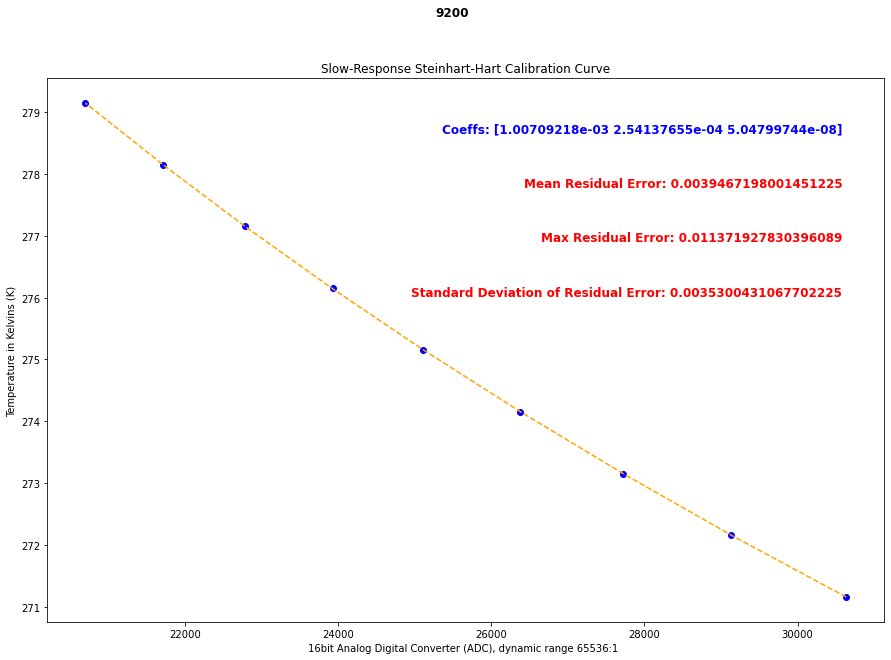

In [102]:
# Steinhart-Hart-Gleichug Equation
# https://de.wikipedia.org/wiki/Steinhart-Hart-Gleichung
# UNDER SeaSurface
# Python script copied from Git-Hub 
# https://gist.github.com/fbaeuerlein/8292eeb7d6a7339dcda9e41a47a93ef8
x = []
y = []

# resistance values in ADC counts
x = (refpd.slow_ADCmean)

# convert temperature of SBEmean in Celsius to absolute temperature in Kelvins (K)
y = (refpd.SBEmean + 273.15)

def shh(x, a0, a1, a2):
    return 1. / (a0 + a1 * np.log(x) + a2 * np.power(np.log(x),3))

# Do the fit with initial values (needed, otherwise no meaningful result)
# params are the SHH Coefficients A, B and C in order.
params, cov = curve_fit(shh, x, y, p0=[1e-4, 1e-4, 1e-4])

# generate curve with fit result
y2 = []
for v in x: 
    y2.append(shh(v, params[0], params[1], params[2]))
    
# calculate residual error values (absolute value difference between y and y2)
errorabs = (np.abs(np.subtract(y, y2)))
max_error = np.max(errorabs)
mean_error = np.mean(errorabs)
errorstd = (np.std(errorabs))
    
#write coefficient and error values to txt file
sys.stdout = open(input_path+'/'+'sr_coeff.txt', 'w')
print("Coeffs: {}".format(params))
print("Max Residual Error: {}".format(max_error))
print("Mean Residual Error: {}".format(mean_error))
print ("Standard Deviation of Residual Error: {}".format(errorstd))
    
# plot original data and result
fig, shh = plt.subplots(figsize=(15,10))
shh.plot(x, y, 'bo') #calibration points
shh.plot(x, y2, color='orange', linestyle='dashed') #SHH calibration curve
shh.set(xlabel='16bit Analog Digital Converter (ADC), dynamic range 65536:1  ', ylabel='Temperature in Kelvins (K)', title='Slow-Response Steinhart-Hart Calibration Curve')

fig.suptitle(sn, fontsize=12, fontweight='bold')


shh.text(0.95, 0.9, "Coeffs: {}".format(params), fontsize=12, fontweight='bold',
         horizontalalignment='right',  
         transform=shh.transAxes,
         color='blue')
shh.text(0.95, 0.8, "Mean Residual Error: {}".format(mean_error), fontsize=12, fontweight='bold',
         horizontalalignment='right',
         transform=shh.transAxes,
         color='red')
shh.text(0.95, 0.7, "Max Residual Error: {}".format(max_error), fontsize=12, fontweight='bold',
         horizontalalignment='right',
         transform=shh.transAxes,
         color='red')
shh.text(0.95, 0.6, "Standard Deviation of Residual Error: {}".format(errorstd), fontsize=12, fontweight='bold',
         horizontalalignment='right',
         transform=shh.transAxes,
         color='red')

#save figure plot for reference
fig.savefig(input_path+'/'+'SR_SHH.png')
plt.show()

STEINHART-HART (SHH) FOR TOPSIDE TEMPERATURE PROBE (TTP)

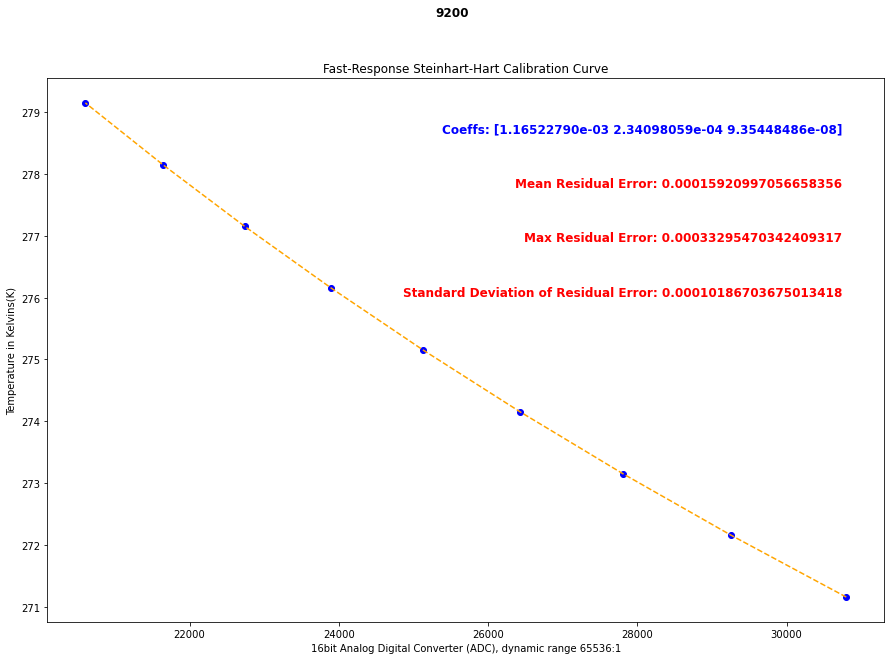

In [103]:
# Steinhart-Hart-Gleichug Equation
# https://de.wikipedia.org/wiki/Steinhart-Hart-Gleichung
# TOP TEMP PROBE (TTP)
# Python script copied from Git-Hub 
# https://gist.github.com/fbaeuerlein/8292eeb7d6a7339dcda9e41a47a93ef8
x = []
y = []

# resistance values in ADC counts
x = (refpd.fast_ADCmean)
# convert temperature of SBEmean in Celsius to absolute temperature in Kelvins (K)
y = (refpd.SBEmean + 273.15)
 
def shh(x, a0, a1, a2):
    return 1. / (a0 + a1 * np.log(x) + a2 * np.power(np.log(x),3))

# Do the fit with initial values (needed, otherwise no meaningful result)
# params are the SHH Coefficients A, B and C in order.
params, cov = curve_fit(shh, x, y, p0=[1e-3, 1e-4, 1e-6])

# generate curve with fit result
y2 = []
for v in x: 
    y2.append(shh(v, params[0], params[1], params[2]))

# calculate residual error values (absolute value difference between y and y2)
errorabs = (np.abs(np.subtract(y, y2)))
max_error = np.max(errorabs)
mean_error = np.mean(errorabs)
errorstd = (np.std(errorabs))

#write coefficient and error values to txt file
sys.stdout = open(input_path+'/'+'fr_coeff.txt', 'w')
print("Coeffs: {}".format(params))
print("Max Residual Error: {}".format(max_error))
print("Mean Residual Error: {}".format(mean_error))
print ("Standard Deviation of Residual Error: {}".format(errorstd))

# plot original data and result
fig, shh = plt.subplots(figsize=(15,10))
shh.plot(x, y, 'bo') #calibration points
shh.plot(x, y2, color='orange', linestyle='dashed') #SHH calibration curve
shh.set(xlabel='16bit Analog Digital Converter (ADC), dynamic range 65536:1', ylabel='Temperature in Kelvins(K)', title='Fast-Response Steinhart-Hart Calibration Curve')

fig.suptitle(sn, fontsize=12, fontweight='bold')


shh.text(0.95, 0.9, "Coeffs: {}".format(params), fontsize=12, fontweight='bold',
         horizontalalignment='right',  
         transform=shh.transAxes,
         color='blue')
shh.text(0.95, 0.8, "Mean Residual Error: {}".format(mean_error), fontsize=12, fontweight='bold',
         horizontalalignment='right',
         transform=shh.transAxes,
         color='red')
shh.text(0.95, 0.7, "Max Residual Error: {}".format(max_error), fontsize=12, fontweight='bold',
         horizontalalignment='right',
         transform=shh.transAxes,
         color='red')
shh.text(0.95, 0.6, "Standard Deviation of Residual Error: {}".format(errorstd), fontsize=12, fontweight='bold',
         horizontalalignment='right',
         transform=shh.transAxes,
         color='red')


fig.savefig(input_path+'/'+'fr_SHH.png')
plt.show()